# Linear Model Maximizing Sharpe Ratio

## Load Data
Use Yahoo Finance library to load the stock prices for Apple.

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

In [2]:
df = yf.download(
    "AAPL",
    start = "1960-01-01",  
    end = "2025-08-31", 
    auto_adjust = True
    )
df = df.droplevel(level='Ticker', axis=1)

[*********************100%***********************]  1 of 1 completed


In [3]:
len(df)

11264

In [4]:
df.head(2)

Price,Close,High,Low,Open,Volume
Date,,,,,
1980-12-12,0.098485,0.098913,0.098485,0.098485,469033600
1980-12-15,0.093347,0.093775,0.093347,0.093775,175884800


In [5]:
df.tail(2)

Price,Close,High,Low,Open,Volume
Date,,,,,
2025-08-20,226.009995,230.470001,225.770004,229.979996,42190600
2025-08-21,225.740005,226.520004,224.510101,226.279999,10610786


## Formatting the Data
Bring the data to a more convenient format.

Rename columns (make the names shorter).

In [6]:
df.rename(columns = {'Open':'o', 'High':'h', 'Low':'l', 'Close':'c', 'Volume':'v'}, inplace = True)

Change the order of the columns to get the standard OHLC order.

In [7]:
df = df[['v','o','h','l','c']]

Data-frame after the polishing (5 random rows).

In [8]:
df.sample(5)

Price,v,o,h,l,c
Date,,,,,
2016-02-02,149428800,21.535107,21.675034,21.277823,21.322962
2023-10-30,51131000,167.380544,169.509683,167.231990,168.638214
1999-09-10,458763200,0.570382,0.583047,0.560532,0.581170
2017-08-08,144823600,36.900750,37.652259,36.823970,37.245094
2011-03-24,404712000,10.262378,10.386962,10.172618,10.356041


## Adding Features and Target

As target we will use Close-to-Close Return, which is most common type of price change in academic finance and backtests.

In [9]:
df.loc[:, 'price_change'] = 100.0 * (df.c.shift(-1) - df.c) / df.c.shift(-1)

In [10]:
# range
mn_15= df.c.rolling(window = 15).min()
mx_15 = df.c.rolling(window = 15).max()
df.loc[:,'rng_15'] = (df.c - mn_15) / (mx_15 - mn_15)

# current price change (not the future one!)
cpc =  100.0 * (df.c - df.c.shift(1)) / df.c

# 15-day and 30-days means
df.loc[:,'avg_15'] = cpc.rolling(window = 15).mean()
df.loc[:,'avg_30'] = cpc.rolling(window = 30).mean()

# ratio of the two means
df.loc[:,'rat'] = df.avg_15 / df.avg_30

df.loc[:,'vol_15'] = cpc.rolling(window = 15).var()

df.loc[:,'skew_30'] = cpc.rolling(window = 30).skew()
df.loc[:,'kurt_30'] = cpc.rolling(window = 30).kurt()

In [11]:
feats = ['rng_15', 'avg_15', 'avg_30', 'rat', 'vol_15', 'skew_30', 'kurt_30']
df = df[feats + ['price_change']].dropna()

In [12]:
df.head()

Price,rng_15,avg_15,avg_30,rat,vol_15,skew_30,kurt_30,price_change
Date,,,,,,,,
1981-01-27,0.666671,-0.092139,0.283292,-0.325243,8.537587,0.056753,-0.471666,-3.225600
1981-01-28,0.285716,-0.010301,0.359246,-0.028673,7.873270,0.099580,-0.382392,-3.765449
1981-01-29,0.000000,-0.123601,0.497770,-0.248310,8.564907,0.411805,-0.754673,-5.752670
1981-01-30,0.000000,-0.846958,0.225504,-3.755843,8.320326,0.414299,-0.724656,-6.102900
1981-02-02,0.000000,-1.201119,-0.071844,16.718484,10.158919,0.442648,-0.667960,3.619689


In [13]:
get_sharpe = lambda x : np.sqrt(252) * np.mean(x) / np.std(x)

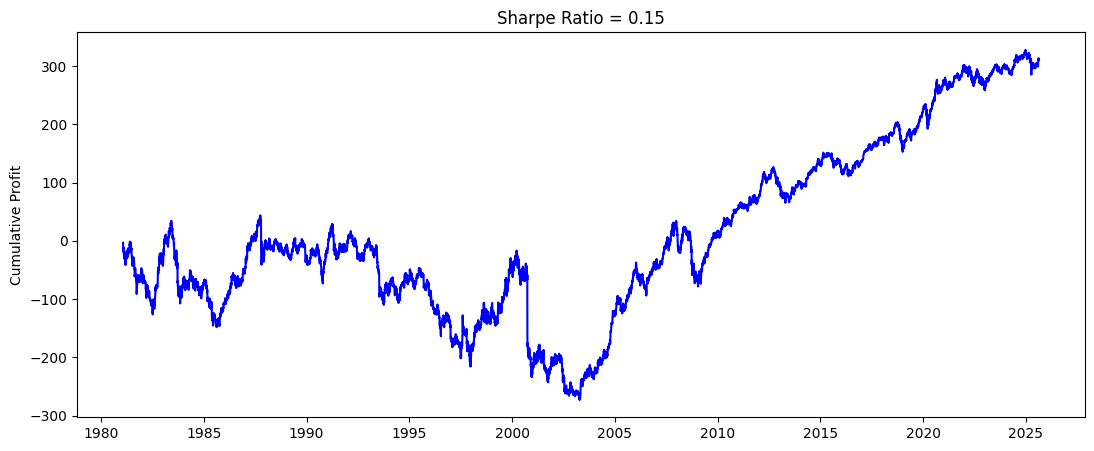

In [14]:
s = round(get_sharpe(df.price_change),2)
plt.figure(figsize = (13,5))
plt.title(f'Sharpe Ratio = {s}')
plt.ylabel('Cumulative Profit')
plt.plot(np.cumsum(df.price_change), color = 'b')
plt.show()

## Random Linear Strategy 

In [15]:
p = np.random.normal(size = 8)
df.loc[:,'position'] = p[0]
for e, feat in enumerate(feats):
    df.loc[:,'position'] += p[e+1] * df[feat]
df.loc[:,'profit'] = df.price_change * df.position

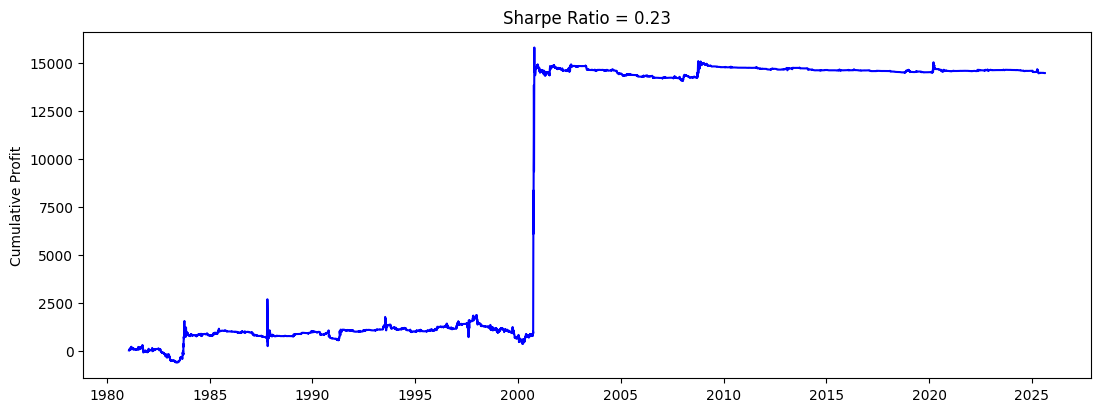

In [16]:
s = round(get_sharpe(df.profit),2)
plt.figure(figsize = (13,4.5))
plt.title(f'Sharpe Ratio = {s}')
plt.ylabel('Cumulative Profit')
plt.plot(np.cumsum(df.profit), color = 'b')
plt.show()

## Use direct optimization to find linear model maximizing Sharpe ratio

For a list of given model parameters calculate "positions" and the corresponding "profits" as well as add them to the data-frame.

In [17]:
def add_profit(df, p):
    df.loc[:,'position'] = p[0]
    for e, feat in enumerate(feats):
        df.loc[:,'position'] += p[e+1] * df[feat]
    df.loc[:,'position'] = df.position / np.max(np.abs(df.position))
    df.loc[:,'profit'] = df.price_change * df.position
    return df

For a given list of model parameters return negative Sharpe ratio.

In [18]:
def cost_func(p):
    global df
    df = add_profit(df, p)
    return -get_sharpe(df.profit)

Define initial values of the parameters and show the corresponding Sharpe ratio.

In [19]:
ini_params = [1.0] + [0.0]*len(feats)
-cost_func(ini_params)

0.1503050620670839

Run an optimization (search for the best model parameters, maximizing Sharpe ratio).

In [20]:
result = minimize(cost_func, ini_params)

Show found model parameters and the corresponding result (Sharpe ratio).

In [21]:
p = result.x / np.max(np.abs(result.x))
print('Parameters:', [round(x,5) for x in p], 'Result:', -result.fun)

Parameters: [-0.44807, 1.0, -0.18307, -0.16315, 0.00569, -0.00512, 0.58907, 0.0922] Result: 0.7497356525927868


In [22]:
df = add_profit(df, p)

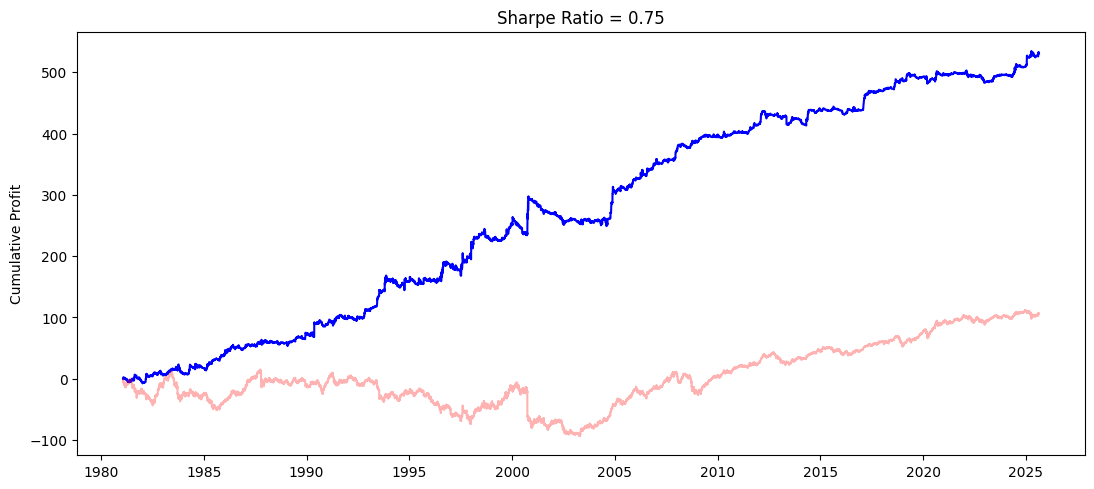

In [23]:
s = round(get_sharpe(df.profit),2)
plt.figure(figsize = (13,5.5))
plt.title(f'Sharpe Ratio = {s}')
plt.ylabel('Cumulative Profit')
plt.plot(np.cumsum(df.profit) / df.profit.std(), color = 'b')
plt.plot(np.cumsum(df.price_change) / df.price_change.std(), color = 'r', alpha = 0.3)
plt.show()

## Analytical Solution

In [24]:
class LinearSharpe:
    
    def __init__(self):
        self.coef_ = None
    
    def fit(self, X, y):
        # 1. Prepend column of 1.0s
        ones = np.ones((X.shape[0], 1))
        X_ext = np.hstack([ones, X])

        # 2. Multiply each column of X_ext elementwise by y
        Xy = X_ext * y[:, np.newaxis]

        # 3. Covariance matrix + column means
        cov_matrix = np.cov(Xy, rowvar=False, bias=False)
        means = np.mean(Xy, axis=0)

        # 4. Inverse covariance matrix
        inv_cov = np.linalg.inv(cov_matrix)

        # 5. Multiply inverse covariance by means vector
        self.coef_ = inv_cov.dot(means)
    
    def predict(self, X):
        if self.coef_ is None:
            raise ValueError("Model is not fitted yet. Call fit() first.")

        # Add intercept term (prepend column of ones)
        ones = np.ones((X.shape[0], 1))
        X_ext = np.hstack([ones, X])

        # 6. Predictions by dot product
        return np.dot(X_ext, self.coef_)

# Use the Model

Train the model and use it to trade (calculate positions).

In [48]:
ls = LinearSharpe()
X = df[feats].values
y = df.price_change.values
ls.fit(X, y)
df.loc[:,'profit'] = df.price_change * ls.predict(X)

Check the Sharpe ratio of the resulting profits.

In [49]:
get_sharpe(df.profit)

0.7877729900871853

Show the found model parameters (after normalization).

In [50]:
print([round(x,3) for x in ls.coef_ /np.max(np.abs(ls.coef_))])

[-0.39, 1.0, -0.293, -0.092, 0.004, -0.006, 0.369, 0.052]


Show the old model parameters (after normalization).

In [51]:
print([round(x,3) for x in p])

[-0.448, 1.0, -0.183, -0.163, 0.006, -0.005, 0.589, 0.092]


Add portions and profits to the data-frame using the above defined function (just to double-check).

In [52]:
df = add_profit(df, ls.coef_)

In [53]:
get_sharpe(df.profit)

0.7877729900871853

## From Liner Dependencies to Polynomial
$$
\pi (x) = c_0 + c_1 \cdot x
$$
$$
\pi (x) = c_0 + c_1 \cdot x + c_2 \cdot x^2 + c_3 \cdot x^3 + \cdots + c_n \cdot x^n = \sum_i^n c_i \cdot x^i
$$

In [136]:
df_new = df[['rng_15', 'price_change']].copy()
df_new.rename(columns = {'rng_15':'f1'}, inplace = True)
for i in [2,3,4,5]:
    df_new.loc[:,'f' + str(i)] = np.power(df_new.f1, i)

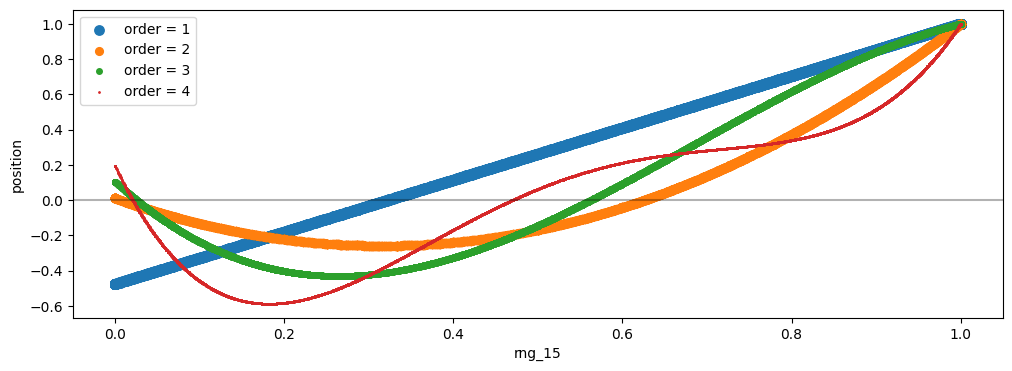

In [146]:
y = df_new.price_change.values
plt.figure(figsize = (12,4))
plt.xlabel('rng_15')
plt.ylabel('position')
for order in range(1,4+1):
    feats = [f'f{j}' for j in range(1,order+1)]
    
    X = df_new[feats].values
    ls.fit(X, y)
    df_new = add_profit(df_new, ls.coef_)
    
    plt.scatter(df_new.f1, df_new.position, label = f'order = {order}', s = (4 - order)*15 + 1)
plt.axhline(y = 0, color = 'k', alpha = 0.3)
plt.legend()
plt.show()

## Sum of Gaussians

$$
\pi (x) = c_1 \cdot \exp[-\alpha \cdot (x - x_1)] + \cdots + c_n \cdot \exp[-\alpha \cdot (x - x_n)] = \sum_i^n c_i \cdot \exp[-\alpha \cdot (x - x_i)]
$$

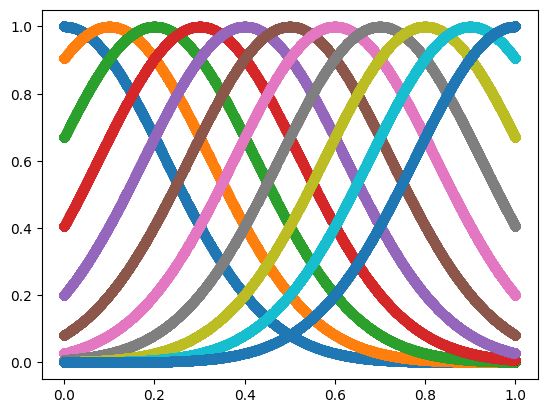

In [149]:
df_new = df[['rng_15', 'price_change']].copy()
df_new.rename(columns = {'rng_15':'f'}, inplace = True)

plt.figure()
feats = []
for e in range(10+1):
    feat = 'f' + str(e)
    df_new.loc[:,feat] = np.exp(-10.0*np.power(df_new.f - e*0.1, 2))
    feats.append(feat)
    plt.scatter(df_new.f, df_new[feat])
plt.show()

In [150]:
X = df_new[feats].values
ls.fit(X, y)
df_new = add_profit(df_new, ls.coef_)

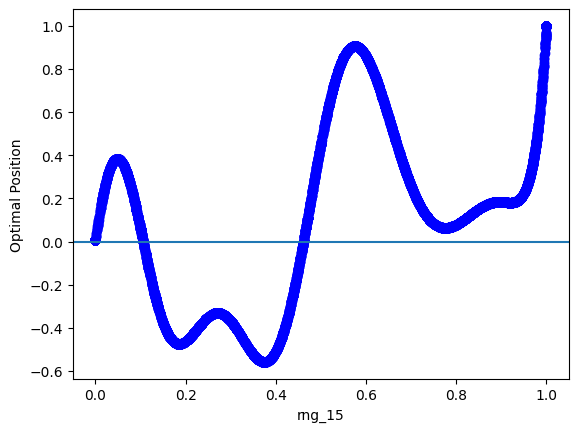

In [151]:
plt.figure()
plt.xlabel('rng_15')
plt.ylabel('Optimal Position')
plt.scatter(df_new.f, df_new.position, color = 'b')

plt.axhline()

# Multivariable Polynomial
$$
x, y, z \rightarrow x, x^2, x^3, \cdots, y, y^2, y^3, \cdots, z, z^2, z^3, \cdots, x y, x z, y z, \cdots x y z, \cdots, x^2 y z^3
$$
$$
\pi (x, y, z) = \sum_i^n \sum_j^n \sum_k^n C_{ijk} \cdot x^i \cdot y^j \cdot z^k
$$